# ME599-006 Applied Optimal Control - Fall 2024

## Final Exam 

## Soham Shirish Phanse
## University of Michigan

Mail: ssphanse@umich.edu

# Library Imports

In [1]:
import numpy as np
from scipy.optimize import minimize
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Define System Parameters

In [2]:
# System parameters
eta = 0.9                   # Efficiency of the motor
C_rr = 0.01                 # Rolling resistance coefficient
m = 500                     # Mass of the vehicle (kg)
g = 9.8                     # Gravitational acceleration (m/s^2)
rho = 1.2                   # Air density (kg/m^3)
C_d = 0.15                  # Drag coefficient
A_ref = 1                   # Reference area (m^2)
dx = 10            # Distance step (m)
dxc = 2                 # Distance step (m) for simulation of continuous system
xfinal = 20000              # in metres
xpreview = 500              # in metres

# Initial conditions
v0 = 15                     # in m/s
E_bat0 = 200000             # in J
x0 = 0                      # in m
t0 = 0                      # s

# MPC parameters
Np = 50                              # Prediction horizon
Nc = 50                              # Control horizon
sim_steps = int(xfinal/dx)  # Total simulation steps (20 km / 10 m) = 2000 steps

# Constraints
v_min, v_max = 0 , 30                # m/s
E_bat_min, E_bat_max = 1000, 200000

# Define Utility Functions

## Solar Power Profile

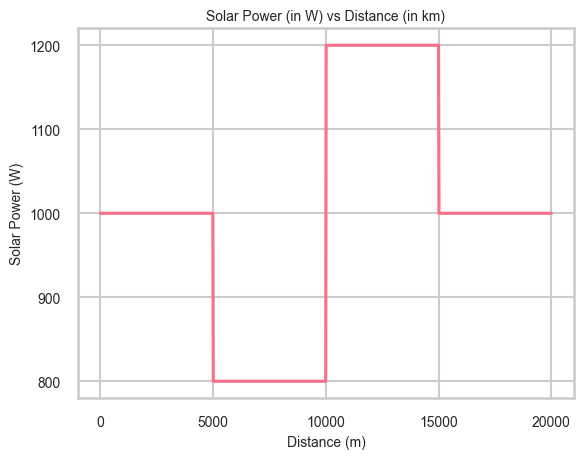

In [3]:
# Solar power function
def solar_power(x):
    if x>=0 and x <= 5000:  # 0-5 km
        return 1000
    elif x>5000 and x <= 10000: # 5-10 km
        return 800
    elif x>10000 and x <= 15000: # 10-15 km
        return 1200
    else: # 15-20 km
        return 1000
    
# plot the solar power function using beautfiul seaborn style
sns.set_context("talk")
sns.set_style("whitegrid")
sns.set_palette("husl")

x = np.linspace(0, xfinal, 1000)
y = [solar_power(i) for i in x]
plt.plot(x,y)
plt.xlabel('Distance (m)', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel('Solar Power (W)', fontsize=10)
plt.title('Solar Power (in W) vs Distance (in km)', fontsize=10)
plt.grid(1)
plt.show()

## System Dynamics

We implement the following system dynamics and update scheme

$$ \dot{E_{bat}} = P_{sun} - \frac{v}{\eta}\left(ma + C_{rr}mg + \frac{1}{2}\rho v^2 C_d A_{ref}\right) $$

$$ E_{bat}(k+1) = E_bat(k) + \frac{dx}{v(k)}*Q(E_{bat}(k)) $$

By, $Q(E_{bat})$, we mean that it can either be $E_{bat}$ or some function of $E_{bat}$ which is usually an RK4 update algorithm or so. 

$$ v(k+1) = \sqrt{v^2(k) + 2a(k)dx} $$

$$ t(k+1) = t(k) + \frac{dx}{v(k)}$$

In [4]:
# System dynamics
def system_dynamics(X, a, P_sun):
    E_bat, v = X                        # State variables
    dE_bat = P_sun - (v/eta) * (m*a + C_rr*m*g + 0.5*rho*v**2*C_d*A_ref)
    dv = a
    return np.array([dE_bat, dv])       # Return the derivative of the state

# RK4 method for state update
"""def rk4_update(X, a, dx):
    E_bat, v, t, x = X
    P_sun = solar_power(x)
    
    k1 = system_dynamics([E_bat, v], a, P_sun)
    k2 = system_dynamics([E_bat + dx/(2*v)*k1[0], v + dx/(2*v)*k1[1]], a, P_sun)
    k3 = system_dynamics([E_bat + dx/(2*v)*k2[0], v + dx/(2*v)*k2[1]], a, P_sun)
    k4 = system_dynamics([E_bat + dx/v*k3[0], v + dx/v*k3[1]], a, P_sun)
    
    E_bat_next = E_bat + (dx/v) * (k1[0] + 2*k2[0] + 2*k3[0] + k4[0]) / 6
    v_next = v + (dx/v) * (k1[1] + 2*k2[1] + 2*k3[1] + k4[1]) / 6
    t_next = t + dx/v
    x_next = x + dx
    
    return np.array([E_bat_next, v_next, t_next, x_next])
"""

# refined rk4 method for state update
def rk4_update(X, a, dx):

    E_bat, v, t, x = X
    P_sun = solar_power(x)
    
    # Update velocity using the equation of motion: v^2 = v_0^2 + 2aΔx
    v_next = v + a*dx/v #can also use the other kinematic approximation = np.sqrt(v**2 + 2*a*dx + eps)
    
    # Calculate average velocity over the step
    v_avg = (v + v_next) / 2
    
    # Update battery energy using RK4
    k1 = P_sun - (v/eta) * (m*a + C_rr*m*g + 0.5*rho*v**2*C_d*A_ref)
    k2 = P_sun - (v_avg/eta) * (m*a + C_rr*m*g + 0.5*rho*v_avg**2*C_d*A_ref)
    k3 = P_sun - (v_avg/eta) * (m*a + C_rr*m*g + 0.5*rho*v_avg**2*C_d*A_ref)
    k4 = P_sun - (v_next/eta) * (m*a + C_rr*m*g + 0.5*rho*v_next**2*C_d*A_ref)
    
    E_bat_next = E_bat + (dx/v_avg) * (k1 + 2*k2 + 2*k3 + k4) / 6
    
    # Update time
    t_next = t + 2*dx / (v + v_next)
    
    # Update position
    x_next = x + dx
    
    return np.array([E_bat_next, v_next, t_next, x_next])

## Cost Function

$$ J(a(k), x(k)) = t(k + N_p | k) - t(k) + 10 \sum_{i=k}^{k + N_p - 1} a^2(i | k) $$

where $k$ is the index of the outer simulation loop, where at each $k$, the MPC predicts the trajectory for the next $N_p$ number of steps, and hence the running cost for that step $k$ is the expected time to traverse that prediction horizon as well as the predicted control output at each step $i$ of the prediction horizon ($i$ is the index of the inner loop).

In [5]:
# Cost function for MPC
def cost_function(a, X):
    E_bat, v, t, x = X                 # extract the state variables
    t_start = t
    J = 0
    for i in range(Np):
        X = rk4_update([E_bat, v, t, x], a[i], dx)  # simulate the system and get the next state
        E_bat, v, t, x = X              # extract the state variables
        J += 10 * a[i]**2               # add penalty for control signal
    J += (t - t_start)                  # add penalty for time taken
    return J

## Non-linear Constraints

We have the following constraints at each step of the outer loop $k$:

$$ 0 \leq v(k) \leq 30 $$
$$ 1000 \leq E_{bat}(k) \leq 200000 $$

Note that the velocity is measured in m/s and Energy of battery is in Joules. 

In [6]:
# Nonlinear constraints for optimization
def nlcon(a, X):
    E_bat, v, t, x = X               # extract the state variables
    c = []
    # Np is the prediction horizon
    for i in range(Np):
        X = rk4_update([E_bat, v, t, x], a[i], dx)                              # simulate the system and get the next state
        E_bat, v, t, x = X                                                      # extract the state variables
        c.extend([v_min - v, v - v_max, E_bat_min - E_bat, E_bat - E_bat_max])  # add constraints
    return np.array(c)

## Main Simulation Loop

1. Create Variables to store the states $E_{bat}, v, t$ and the independent variable $x$ as well as the control input.
2. We start looping through the outer loop, here the index $k$ runs from 0 to N-1, note that this $N$ is not equal to $N_p$. $$ N = \frac{x_f}{\Delta x}$$
3. Store the state values at the current iteration index $k$.
4. Define bounds on the control input if applicable. 
5. Define constraints on the decision variable.
6. Define the objective function and minimize. Note that in the scipy.minimize function, we are sending a function palceholder which depends on acceleration, and for the given cost function (remember that the cost function is computed for the next $N_p$ steps), constraints. We also send in an arbitary initial value of the initial acceleration as an initial guess to the optimization function. (check variable `a_init` : we can also define `a_init` as a constant array taking acceleration values from the previous step as a warm start)
7. We consider the first control signal (first as in, first step) of the generated control output for the next $N_p$ steps. And we propagate the states with this new acceleration value.
8. Now there is another small trick in here, to improve the accuracy of the MPC model, we can simulate the system at smaller timesteps than used for the outer loops, hence if the outer loop step is $\Delta$, and inner update loop step is $\delta$, and we consider the acceleration to be constant over the inner loop. We can also choose to keep it simple and only simulate using the same outer loop timestep. 

In [7]:
# Main simulation loop
x_array = [x0]
v_array = [v0]
E_bat_array = [E_bat0]
t_array = [t0]
a_array = []

for k in tqdm(range(sim_steps - 1)):
    X = np.array([E_bat_array[k], v_array[k], t_array[k], x_array[k]])
    
    # Solve MPC optimization problem
    a_init = np.zeros(Np)                           # initial guess for control signal
    bounds = [(-10, 10)] * Np                   
    cons = {'type': 'ineq', 'fun': lambda a: -nlcon(a, X)}  # nonlinear constraints
    result = minimize(lambda a: cost_function(a, X), a_init, method='SLSQP', bounds=bounds, constraints=cons) # optimization
    
    a = result.x[0]
    a_array.append(a)       # only store the first control signal
    
    # continous system simulation
    # Update state using RK4 method - using smaller step size for inner loop
    ac = np.ones(int(dx/dxc)) * a
    for jj in range(int(dx/dxc)):
        X_next = rk4_update(X, ac[jj], dxc)
        X = X_next

    #X_next = rk4_update(X, a, dxc) # normal - using same step as outer loop
    
    E_bat_array.append(X_next[0])
    v_array.append(X_next[1])
    t_array.append(X_next[2])
    x_array.append(X_next[3])
    
    # Break if we've reached the end of the race
    if x_array[-1] >= xfinal:
        break

100%|██████████| 1999/1999 [08:27<00:00,  3.94it/s]  


## Plot

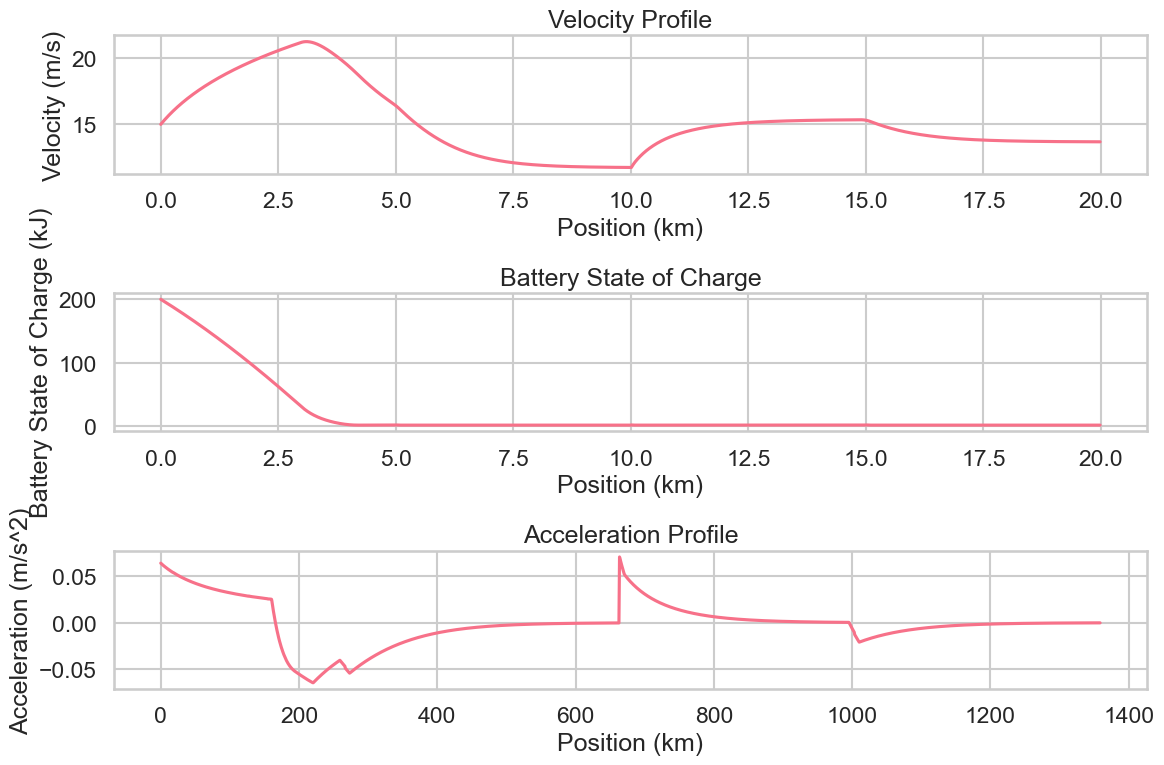

Race completion time: 1359.39 seconds


In [8]:
# Plot results
# make beautiful plots using seaborn
sns.set_context("talk")
sns.set_style("whitegrid")
sns.set_palette("husl")

fig, axs = plt.subplots(3, 1, figsize=(12, 8))

axs[0].plot(np.array(x_array[:-1])/1000, v_array[:-1])
axs[0].set_xlabel('Position (km)')
axs[0].set_ylabel('Velocity (m/s)')
axs[0].set_title('Velocity Profile')

axs[1].plot(np.array(x_array[:-1])/1000, np.array(E_bat_array[:-1])/1000)
axs[1].set_xlabel('Position (km)')
axs[1].set_ylabel('Battery State of Charge (kJ)')
axs[1].set_title('Battery State of Charge')

axs[2].plot(np.array(t_array[:-1]), a_array)
axs[2].set_xlabel('Position (km)')
axs[2].set_ylabel('Acceleration (m/s^2)')
axs[2].set_title('Acceleration Profile')

plt.tight_layout()
plt.show()

print(f"Race completion time: {t_array[-1]:.2f} seconds")